<h1>Rocket Simulation</h1>
<p>Since the numbers are all so large here, it doesn't seem like a vpython application is the right move here. Instead, I'll use Matplotlib for visualization. The goal is to build up a successively complex rocket simulation that incorporates drag and other forces that I've learned about thus far in intro mechanics.</p>
<p>The performance of this rocket will be based loosley on the Delta II. For specs, I used the following source: https://www.spacelaunchreport.com/delta2.html.</p>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter
import numpy as np
from rocket import *
from vector import Vector
from math import exp, isclose
import json

Rocket Stats: 

Drag Coefficient: 0.82
Cross Sectional Area: 7.07 m^2
Stage dry mass is 5680.00kg, fuel mass is 96120.00kg, max thrust is 1100000.00N, and max fuel comsumption rate is 368.98kg/s.

Stage dry mass is 950.00kg, fuel mass is 6000.00kg, max thrust is 43640.00N, and max fuel comsumption rate is 13.90kg/s.

Payload mass is 3680.00kg.

Total mass: 164750.00 kg
9000
{'cmds': [{'throttle': 100.0, 'ignite_srbs': True, 'summary': 'Ignition of main stage.'}]}
{'throttle': 100.0, 'ignite_srbs': True, 'summary': 'Ignition of main stage.'}
Summary: Ignition of main stage.
{'cmds': [{'separate_srbs': True, 'summary': 'SRB separtation.'}]}
{'separate_srbs': True, 'summary': 'SRB separtation.'}
Summary: SRB separtation.
{'cmds': [{'throttle': 0.0, 'summary': 'MECO-1'}]}
{'throttle': 0.0, 'summary': 'MECO-1'}
Summary: MECO-1
{'cmds': [{'separate': True, 'summary': 'Stage Separation'}]}
{'separate': True, 'summary': 'Stage Separation'}
Summary: Stage Separation
{'cmds': [{'throttle': 100.0

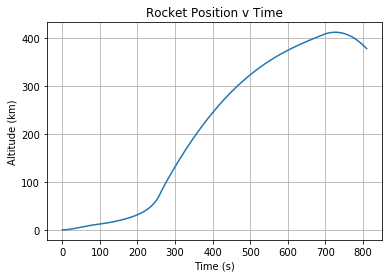

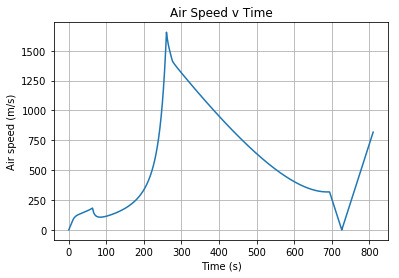

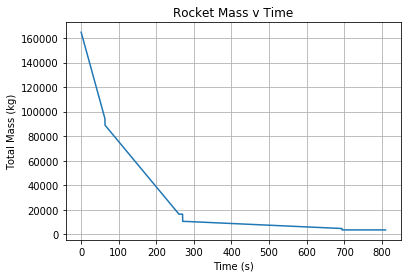

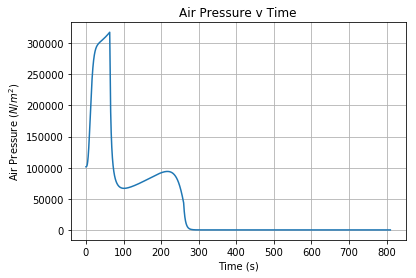

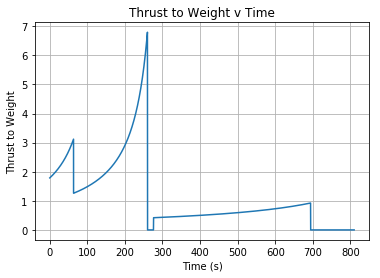

Max Q is 317522.65N/m^2.


In [7]:
# world constants and variables
g = 9.8 # acceleration due to gravity near the Earth's surface
dt = 0.01 # simulation time step
t = 0 # simulation time

# atmosphere
rho_air = lambda altitude: 1.225*exp(-altitude/8500) # atmospheric density as a function of altitude

def atmo_pressure(altitude):
    if altitude >= 2.5E4:
        T = -131.21 + 0.00299*altitude
        P = 2.488*((T+273.1)/216.6)**-11.388
    elif altitude >= 1.1E4 and altitude < 2.5E4:
        T = -56.46
        P = 22.65*np.exp(1.73 - 0.000157*altitude)
    else:
        T = 15.04 - 0.00649*altitude
        P = 101.29*((T+273.1)/288.08)**5.256
        
    #convert from kPa to Pa and return
    return P*1000

# Create a rocket
deltaII = Rocket(pos=Vector(0,0,0), coeff_drag=0.82, cross_sec_area=np.pi*1.5**2)
# rocket stages
main_stage = Stage({"dry_mass": 5.680E3, "fuel_mass": 9.6120E4, "max_thrust_mag": 1.10E6, "max_dmdt": 368.98, "length": 26.1}) #8.89659E5
second_stage = Stage({"dry_mass": 950.0, "fuel_mass": 6000.0, "max_thrust_mag": 4.3640E4, "max_dmdt": 13.9, "length": 6})
deltaII.add_stage(main_stage)
deltaII.add_stage(second_stage)
# SRBs
srb1 = Stage({"dry_mass": 1310.0, "fuel_mass": 11770.0, "max_thrust_mag": 4.46006E5, "max_dmdt": 185.9, "length": 13.1})
srb2 = Stage({"dry_mass": 1310.0, "fuel_mass": 11770.0, "max_thrust_mag": 4.46006E5, "max_dmdt": 185.9, "length": 13.1})
srb3 = Stage({"dry_mass": 1310.0, "fuel_mass": 11770.0, "max_thrust_mag": 4.46006E5, "max_dmdt": 185.9, "length": 13.1})
srb4 = Stage({"dry_mass": 1310.0, "fuel_mass": 11770.0, "max_thrust_mag": 4.46006E5, "max_dmdt": 185.9, "length": 13.1})
deltaII.add_srb(srb1)
deltaII.add_srb(srb2)
deltaII.add_srb(srb3)
deltaII.add_srb(srb4)
# payload
payload = Payload(mass=3680.0, length=8.49)
deltaII.add_payload(payload)

print(deltaII)

# load flight plan from file
with open('flt-plan.json') as f:
  flt_plan = json.load(f)

total_data_points = 0

# EOM command should always be the last record in the flight plan. Read the time for EOM and use that to compute the size of our telemetry arrays.
try:
    cmd = flt_plan[-1]
    try:
        total_data_points = int(float(next(iter(cmd)))) * 10
        print(total_data_points)
    except:
        raise ValueError
except:
    print("The flight plan is empty.")
    raise NoFlightPlanError

total_data_points    

# telemetry arrays
idx = 0
data_point_counter = 0
data_time = np.zeros(total_data_points)
data_altitude = np.zeros(total_data_points)
data_velocity = np.zeros(total_data_points)
data_mass = np.zeros(total_data_points)
data_pressure = np.zeros(total_data_points)
data_thrustweight = np.zeros(total_data_points)

def check_flt_plan(time):
    global flt_plan, EOM
    tm = "{:0.2f}".format(time)
    menu = next((d for i,d in enumerate(flt_plan) if tm in d), None)
    if menu is not None:
        # loop through instruction set
        menu = menu.get(tm)
        print(menu)
        cmds = menu.get("cmds", [])
        # loop through the commands in this menu and execute them in turn
        for cmd in cmds:
            print(cmd) # TODO: remove this statement once all flt plan commands are debugged.
            if cmd.get("throttle", None) is not None:
                deltaII.adjust_throttle(cmd["throttle"])
            if cmd.get("ignite_srbs", None) is not None:
                deltaII.ignite_srbs()
            if cmd.get("separate", None) is not None:
                deltaII.separate_active_stage()
            if cmd.get("separate_srbs", None) is not None:
                deltaII.separate_srbs()
            if cmd.get("EOM", None) is not None:
                EOM = True
            # print command summary
            print("Summary: {:}".format(cmd.get("summary", "None")))

def compute_drag_force(velocity):
    global deltaII
    
    drag_pow = 2.72
    speed = velocity.mag()
    altitude = deltaII.pos.y
    atmo_coeff = 50000/(altitude + 1)
        
    return -1/2*deltaII.coeff_drag*deltaII.cross_sec_area*rho_air(altitude)*speed**drag_pow*velocity.hat()
            
EOM = False
while not EOM:
    
    # check flight plan for updates
    check_flt_plan(t)
    
    # calculate net force on rocket
    Fgrav = Vector(0,-deltaII.get_total_mass()*g,0)
    velocity = deltaII.momentum/deltaII.get_total_mass()
    
    if velocity.mag() > 0:
        Fdrag = compute_drag_force(velocity)
    else:
        Fdrag = Vector(0,0,0)
        
    Fnet = deltaII.get_total_thrust() + Fgrav + Fdrag
    
    # update the rocket's momentum
    deltaII.momentum = deltaII.momentum + Fnet*dt
    
    # update the rockets position
    deltaII.pos = deltaII.pos + deltaII.momentum/deltaII.get_total_mass()*dt
    
    deltaII.update_total_mass(dt)
    
    if data_point_counter == 9 and idx < total_data_points:
        data_point_counter = 0
        data_time[idx] = t
        data_altitude[idx] = deltaII.pos.y
        data_velocity[idx] = (deltaII.momentum/deltaII.get_total_mass()).mag()
        data_mass[idx] = deltaII.get_total_mass()
        data_pressure[idx] = atmo_pressure(deltaII.pos.y) + Fdrag.mag()/deltaII.cross_sec_area
        data_thrustweight[idx] = deltaII.get_total_thrust().mag()/Fgrav.mag()
        idx += 1
    
    data_point_counter += 1
    t += dt

@ticker.FuncFormatter
def major_formatter(x, pos):
    return "[%.2f]" % x        
        
ax = plt.axes()
#ax.yaxis.set_major_formatter(major_formatter)
plt.plot(data_time, data_altitude/1000)
plt.title('Rocket Position v Time')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.show()

plt.title('Air Speed v Time')
plt.plot(data_time, data_velocity)
plt.xlabel('Time (s)')
plt.ylabel('Air speed (m/s)')
plt.grid(True)
plt.show()

plt.title('Rocket Mass v Time')
plt.plot(data_time, data_mass)
plt.xlabel('Time (s)')
plt.ylabel('Total Mass (kg)')
plt.grid(True)
plt.show()

plt.title('Air Pressure v Time')
plt.plot(data_time, data_pressure)
plt.xlabel('Time (s)')
plt.ylabel('Air Pressure ($N/m^2$)')
plt.grid(True)
plt.show()

plt.title('Thrust to Weight v Time')
plt.plot(data_time, data_thrustweight)
plt.xlabel('Time (s)')
plt.ylabel('Thrust to Weight')
plt.grid(True)
plt.show()

max_Q = np.amax(data_pressure)
print("Max Q is {:0.2f}N/m^2.".format(max_Q))